AI for Medical Sciences and Psychology by Tshepo Chris Nokeri, Apress. 2022

# Chapter 6 A Case for COVID-19 CT Scan Segmentation

This chapter presents an approach for carrying out convolutional neural networks to model chest CT scan images and differentiate between patients with and without COVID-19.

In [32]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("talk","ticks", font_scale = 1, font = "Calibri")
from pylab import rcParams
plt.rcParams["figure.dpi"] = 300
import tensorflow as tf
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
import cv2
import shutil
import glob
import os

In [33]:
covid_19_positive_data = r"C:\Users\i5 lenov\Desktop\Next_Chapter\source_code\cov_19_ct_scans"
covid_19_positive_categories = ["CT_COVID"]
for x in covid_19_positive_categories:
    directory = os.path.join(covid_19_positive_data, x)
    for covid_19_positive_image in os.listdir(directory):
        covid_19_positive_images = cv2.imread(os.path.join(directory, covid_19_positive_image))

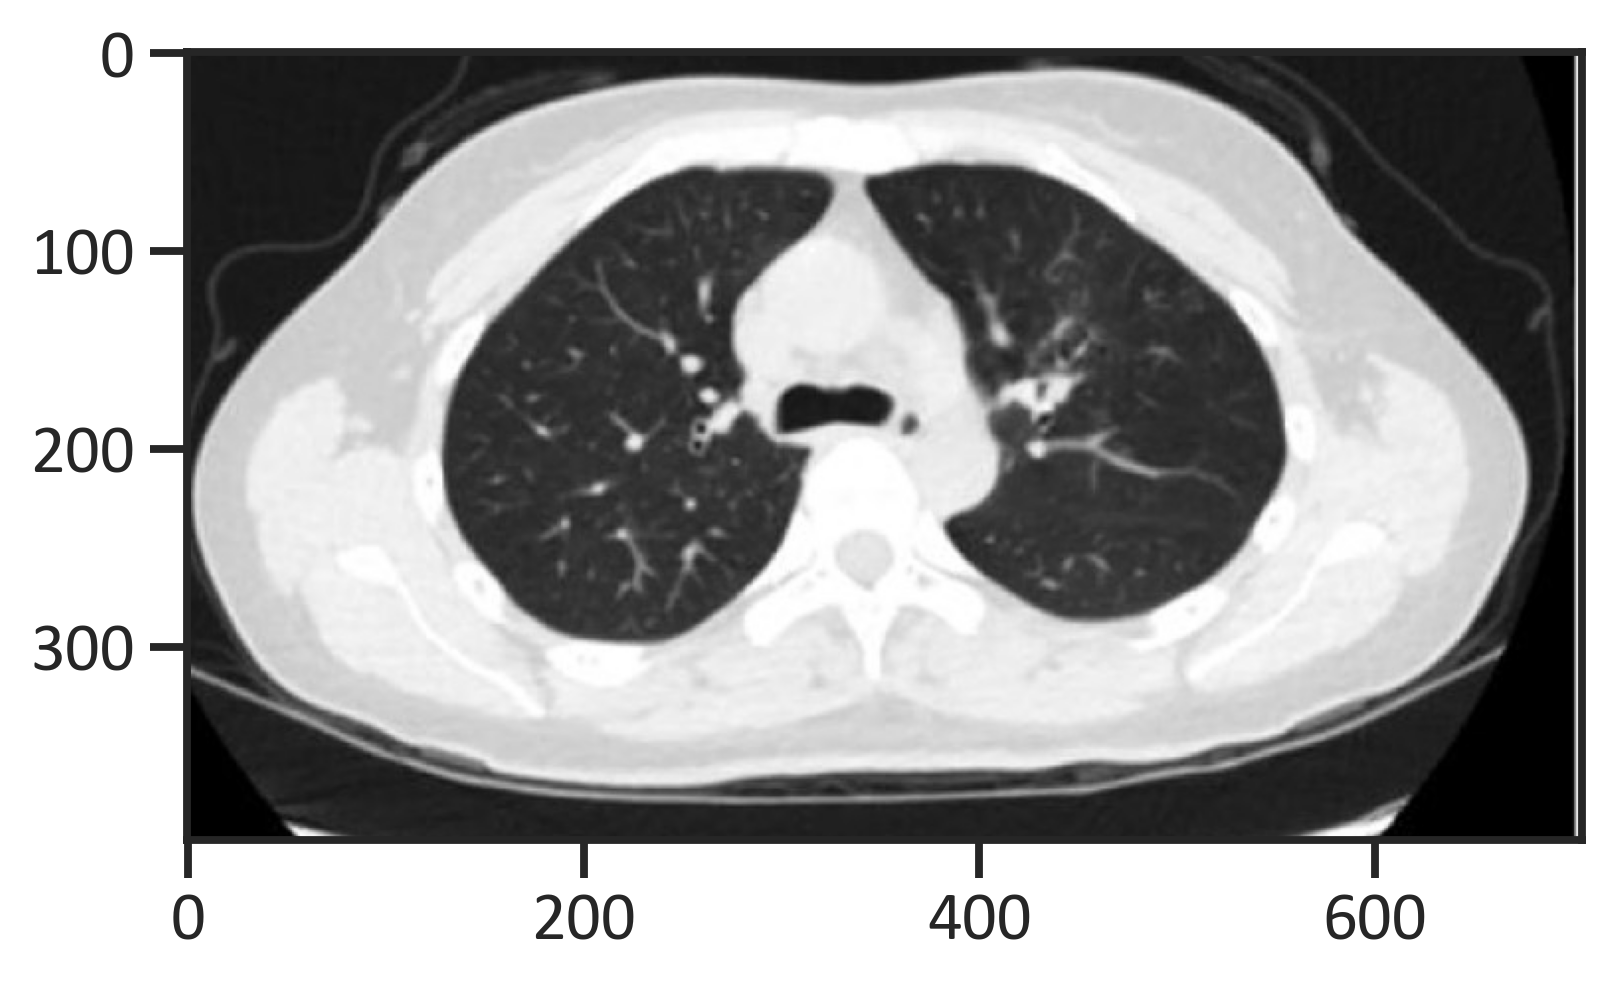

In [34]:
plt.imshow(covid_19_positive_images)
plt.show()

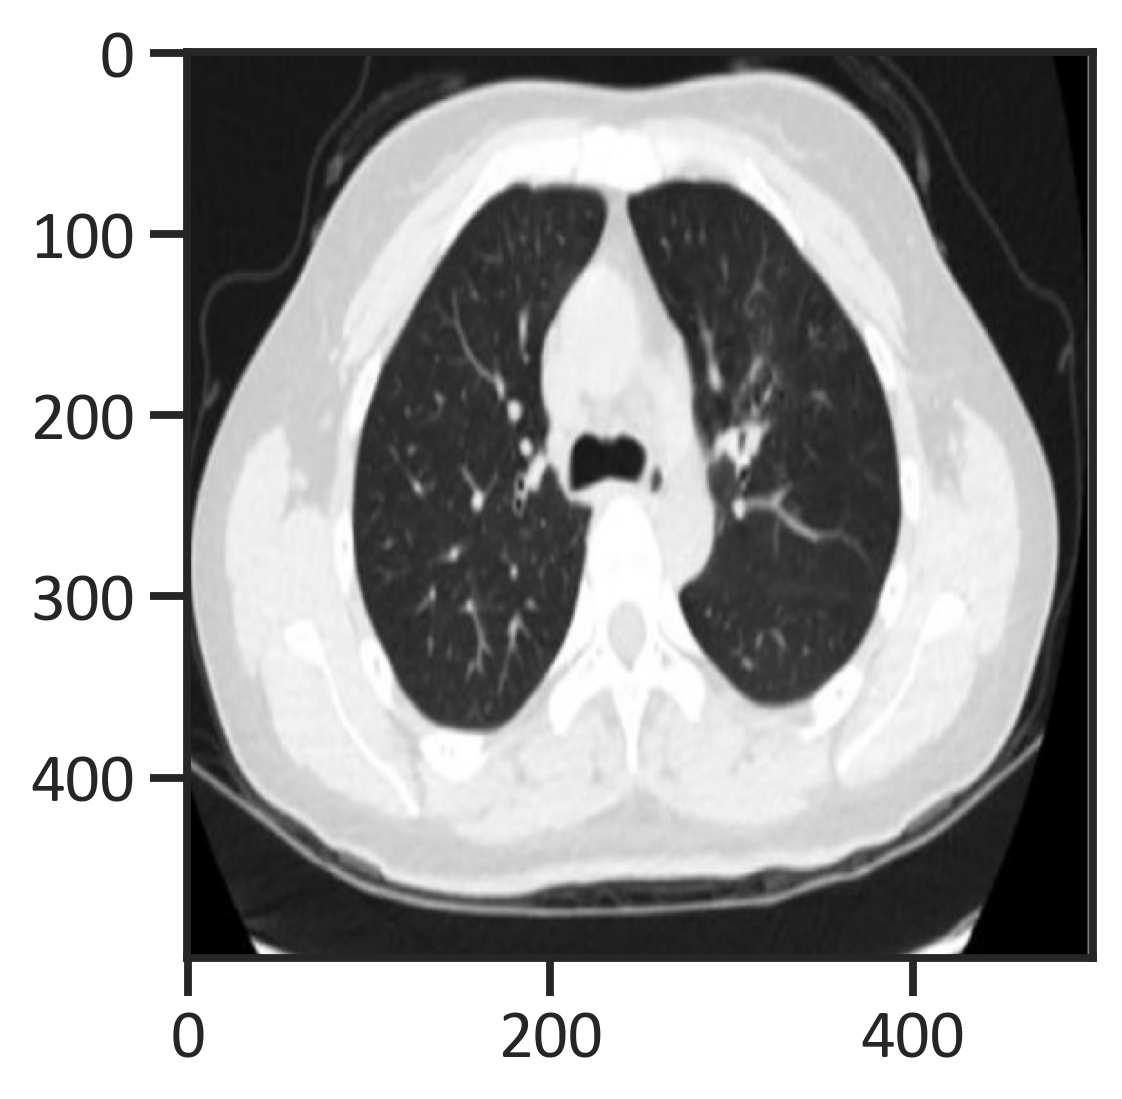

In [35]:
resized_image = cv2.resize(covid_19_positive_images, (500, 500))    
plt.imshow(resized_image)
plt.show()

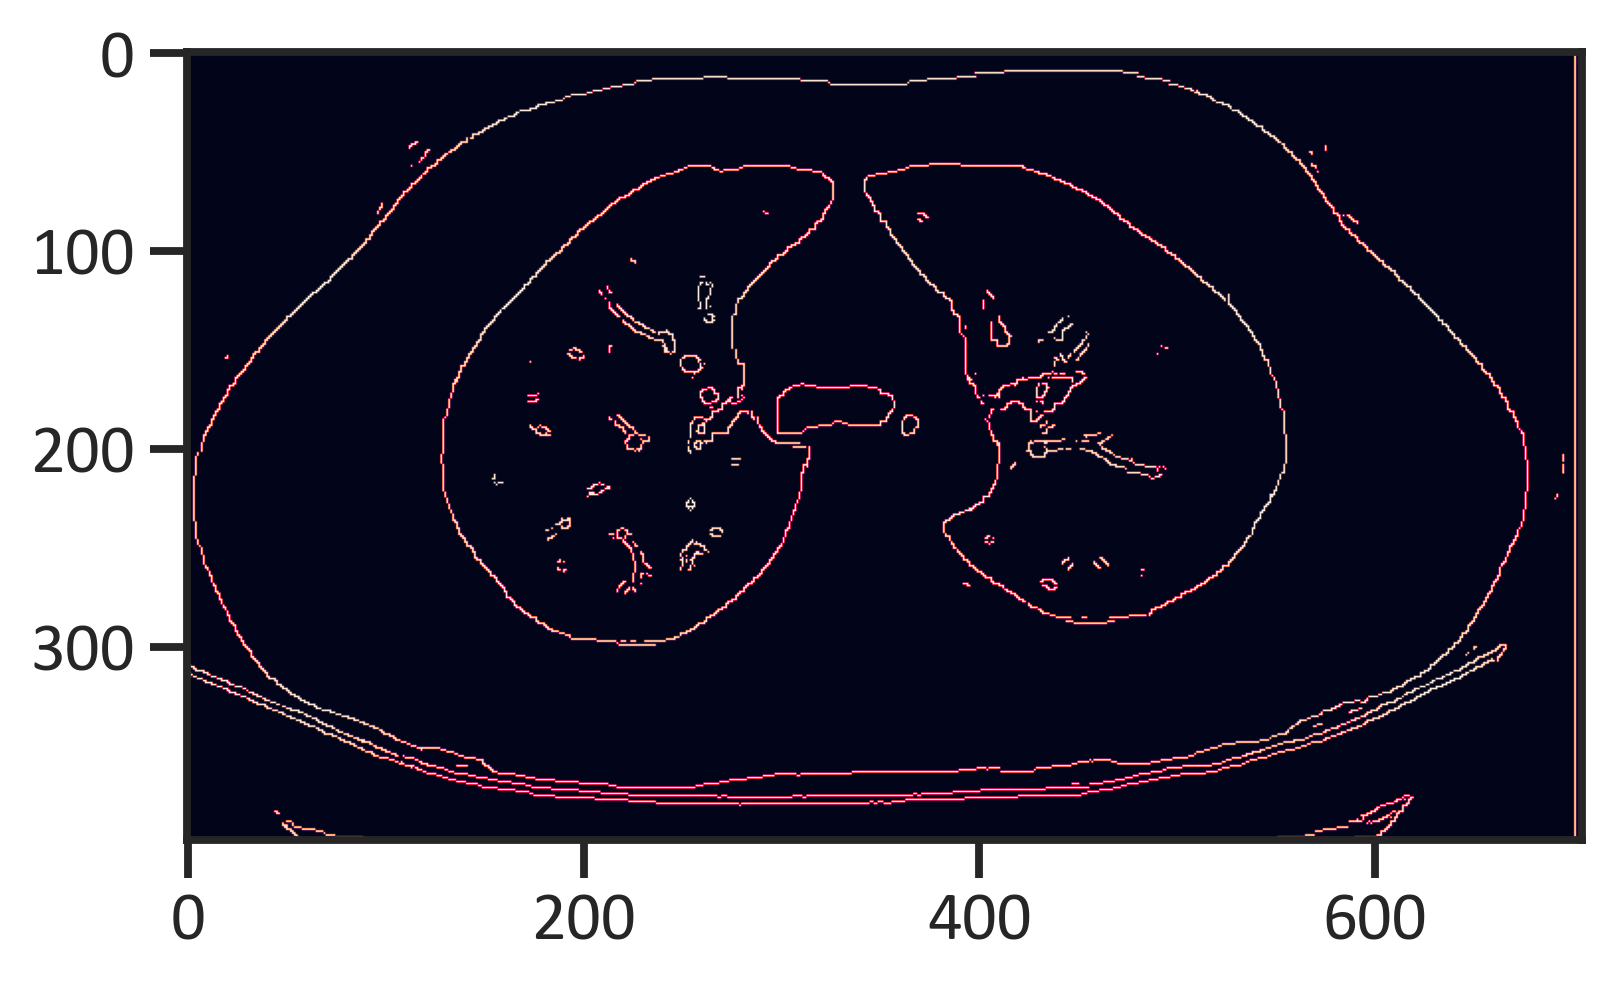

In [36]:
canny_covid_19_positive_images = cv2.Canny(covid_19_positive_images, 180, 180)
plt.imshow(canny_covid_19_positive_images)
plt.show()

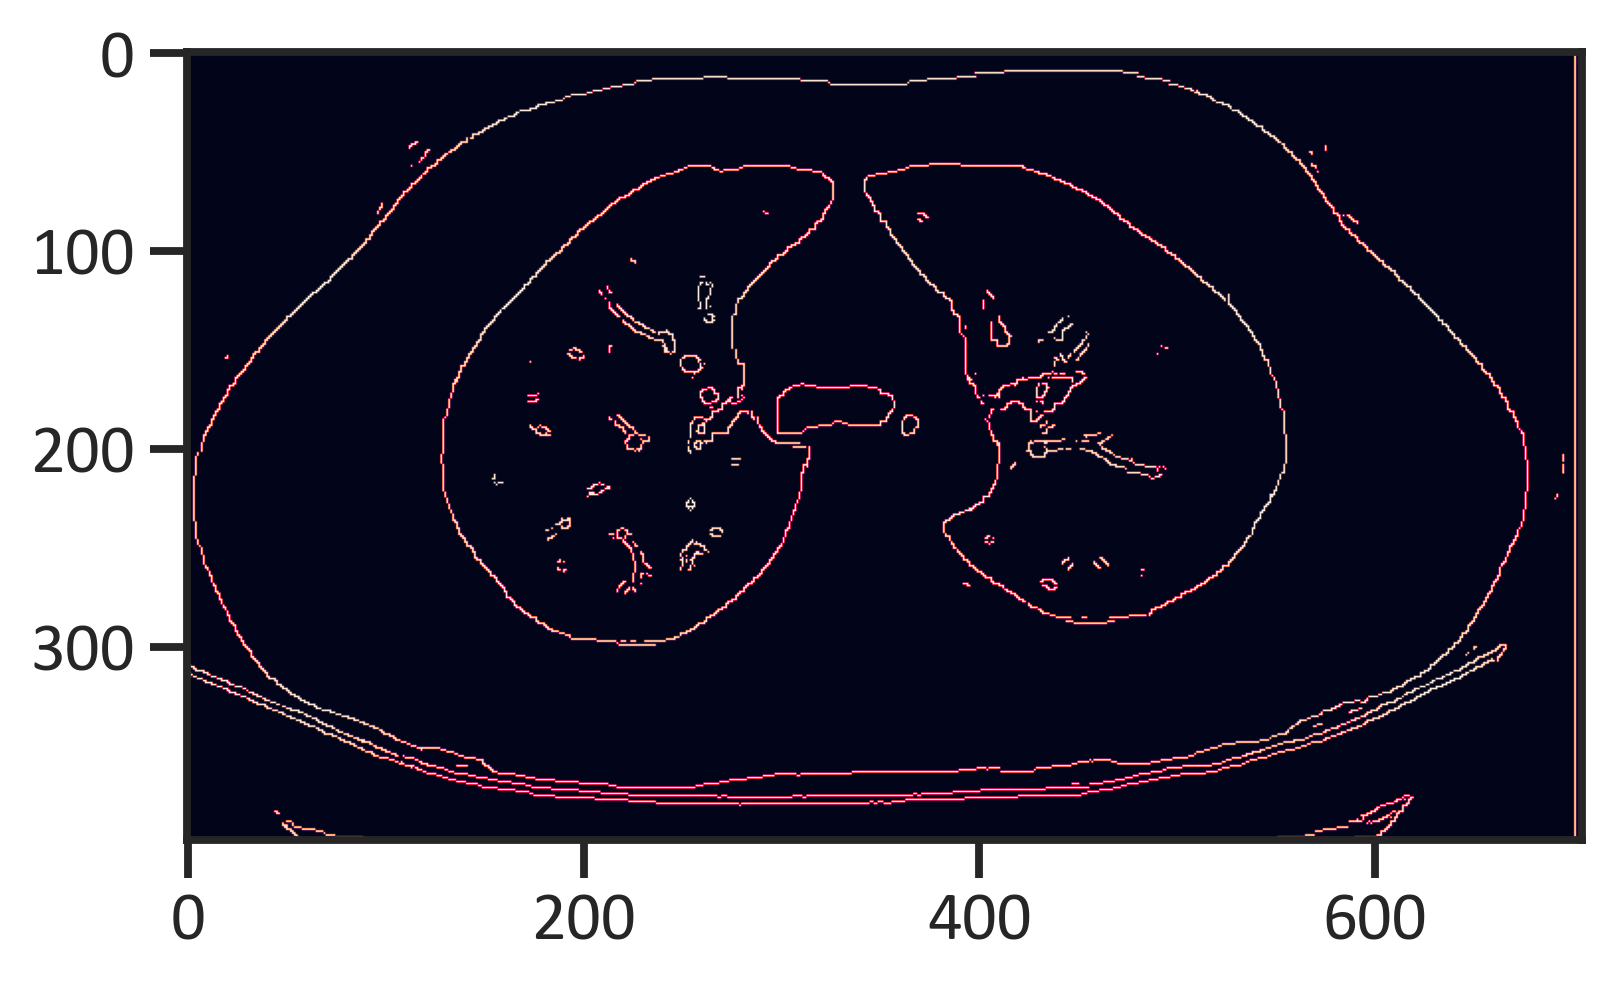

In [37]:
laplacian_covid_19_positive_images = cv2.Laplacian(covid_19_positive_images, cv2.CV_64F)
plt.imshow(canny_covid_19_positive_images)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


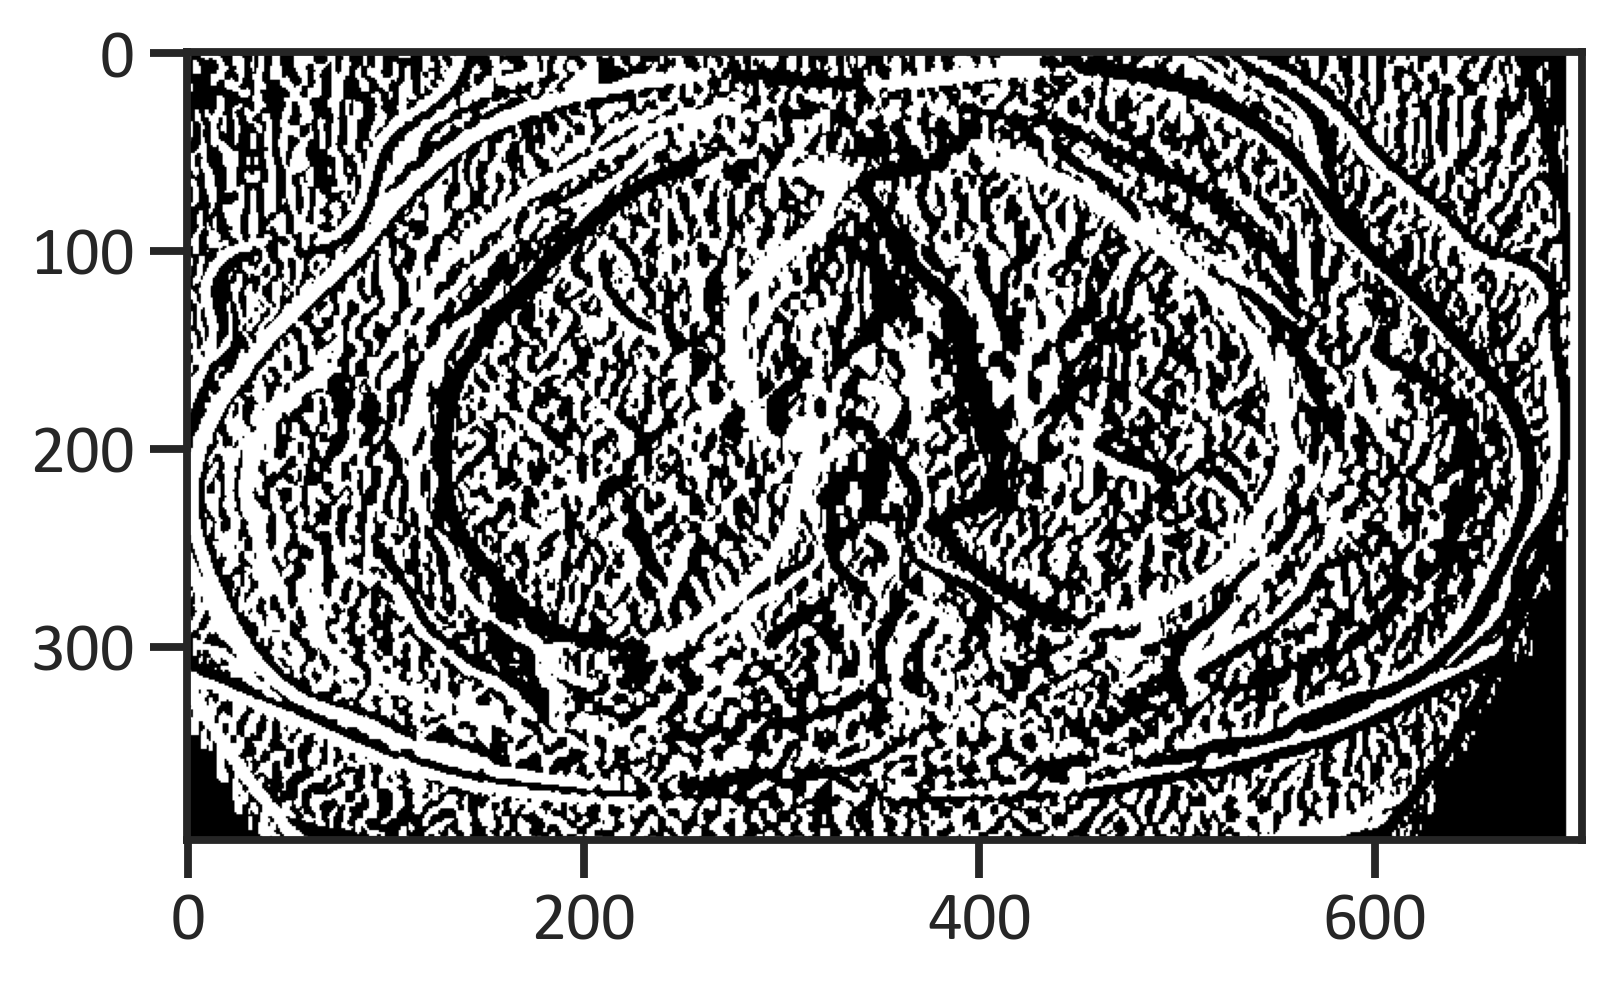

In [38]:
sobel_covid_19_positive_images = cv2.Sobel(covid_19_positive_images, cv2.CV_64F, 1, 0, ksize=5)
plt.imshow(sobel_covid_19_positive_images)
plt.show()

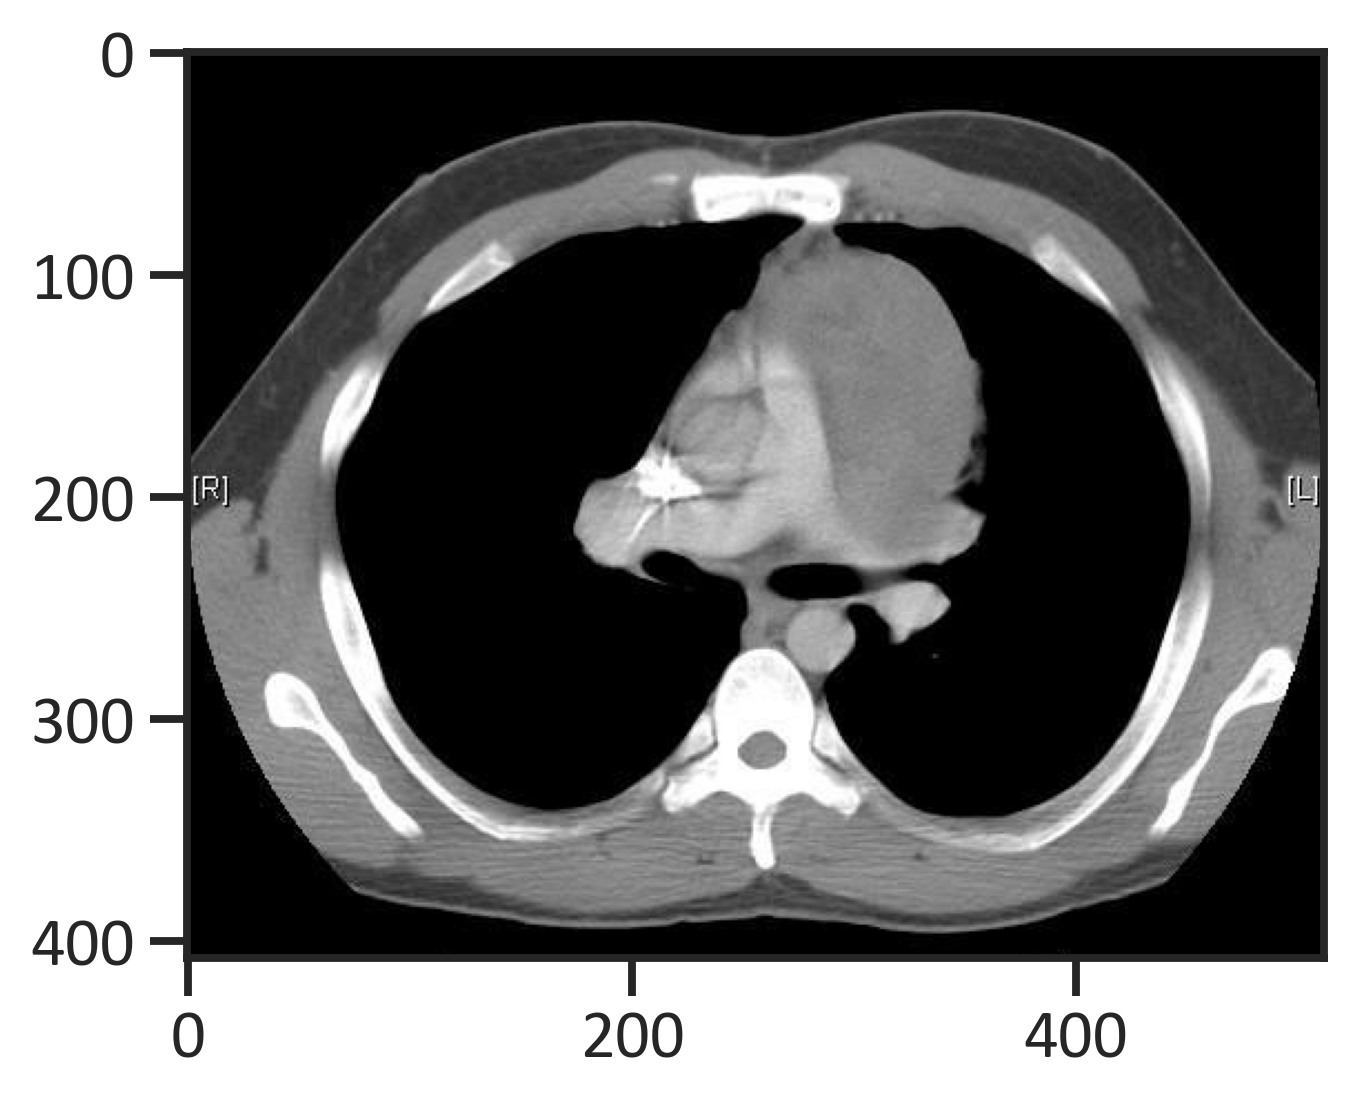

In [39]:
covid_19_negative_data = r"C:\Users\i5 lenov\Desktop\Next_Chapter\source_code\cov_19_ct_scans"
covid_19_negative_categories = ["CT_NonCOVID"]
for x in covid_19_negative_categories:
    directory = os.path.join(covid_19_negative_data, x)
    for covid_19_negative_image in os.listdir(directory):
        covid_19_negative_images = cv2.imread(os.path.join(directory, covid_19_negative_image))
plt.imshow(covid_19_negative_images)
plt.show()

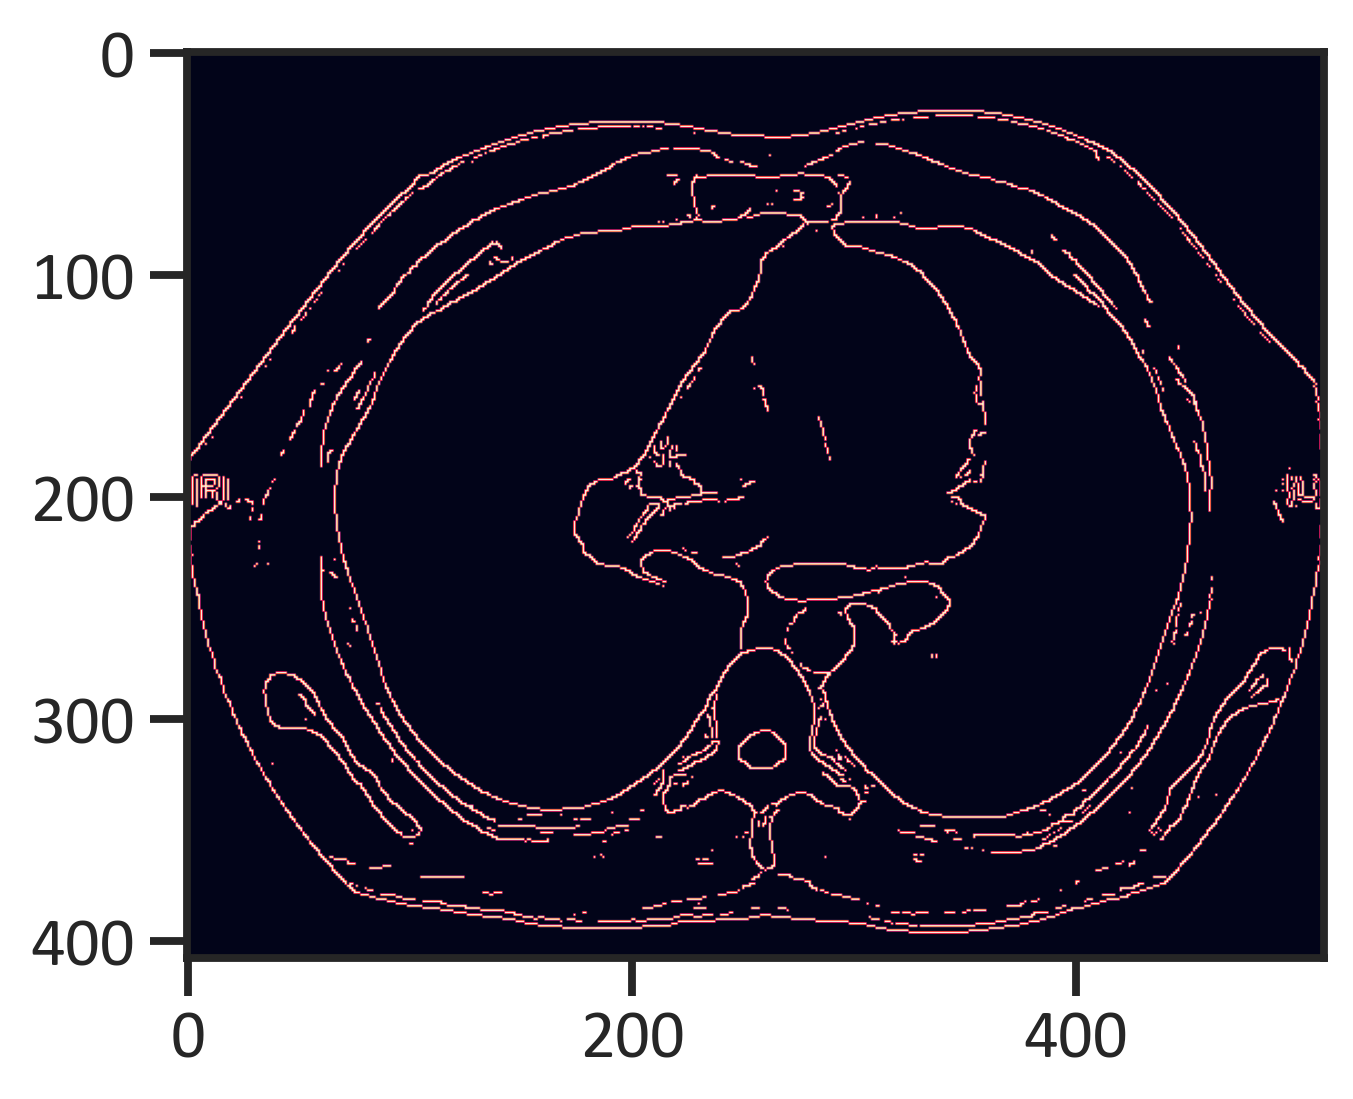

In [40]:
canny_covid_19_negative_images = cv2.Canny(covid_19_negative_images, 180, 180)
plt.imshow(canny_covid_19_negative_images)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


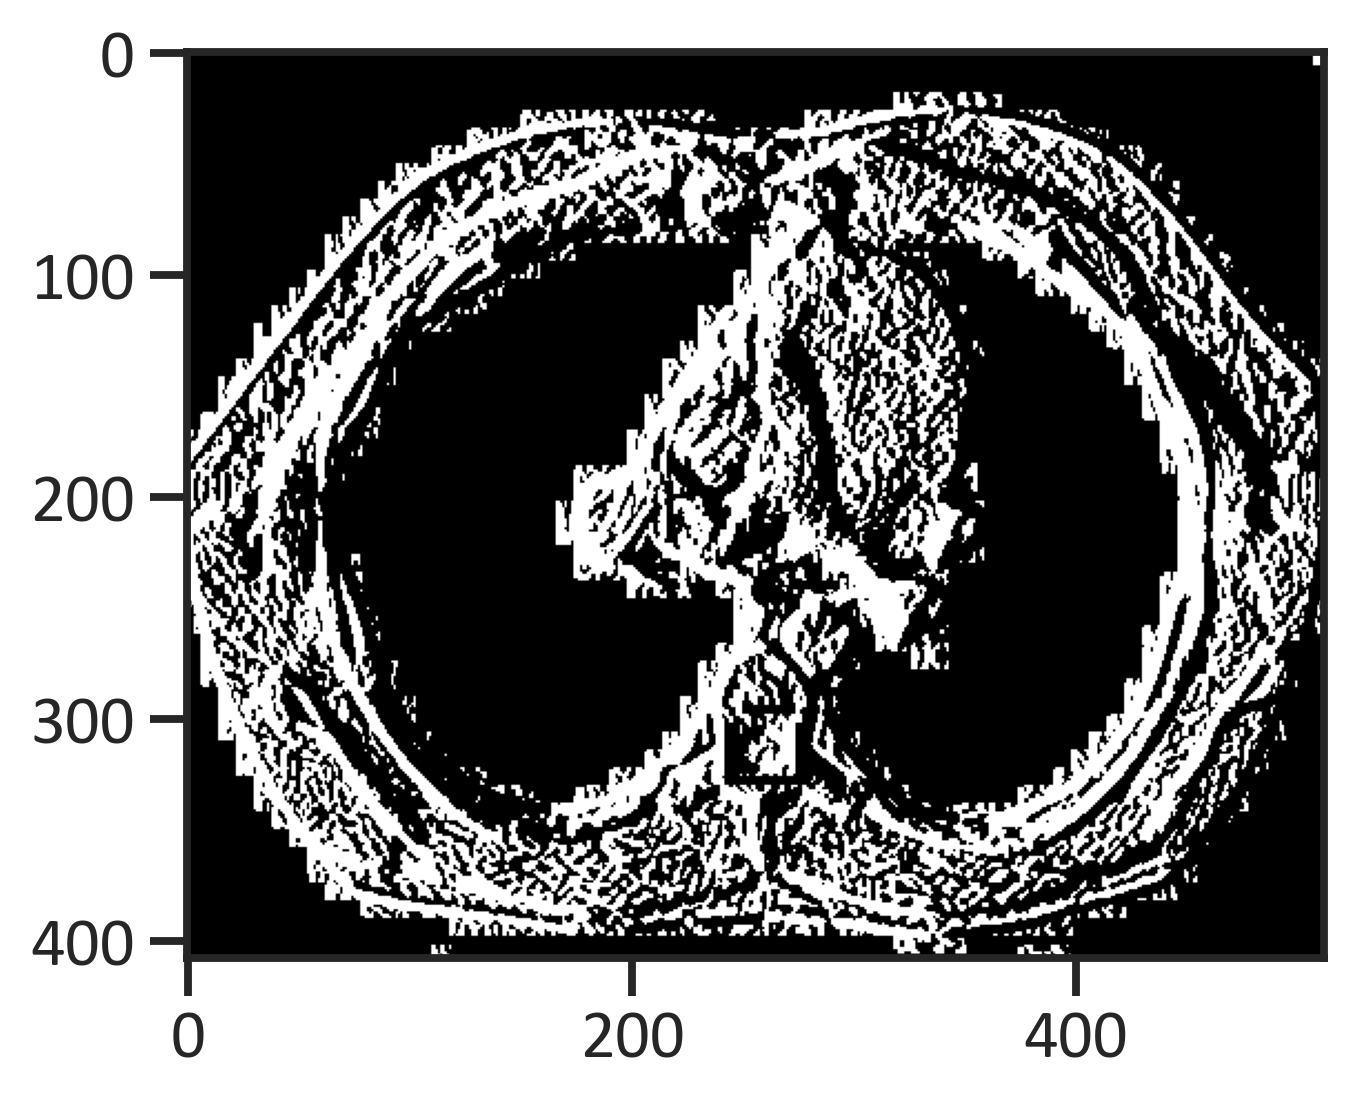

In [41]:
sobel_covid_19_negative_images = cv2.Sobel(covid_19_negative_images, cv2.CV_64F, 1, 0, ksize=5)
plt.imshow(sobel_covid_19_negative_images)
plt.show()

Found 746 files belonging to 2 classes.
Using 597 files for training.
Found 746 files belonging to 2 classes.
Using 149 files for validation.
Found 746 images belonging to 2 classes.


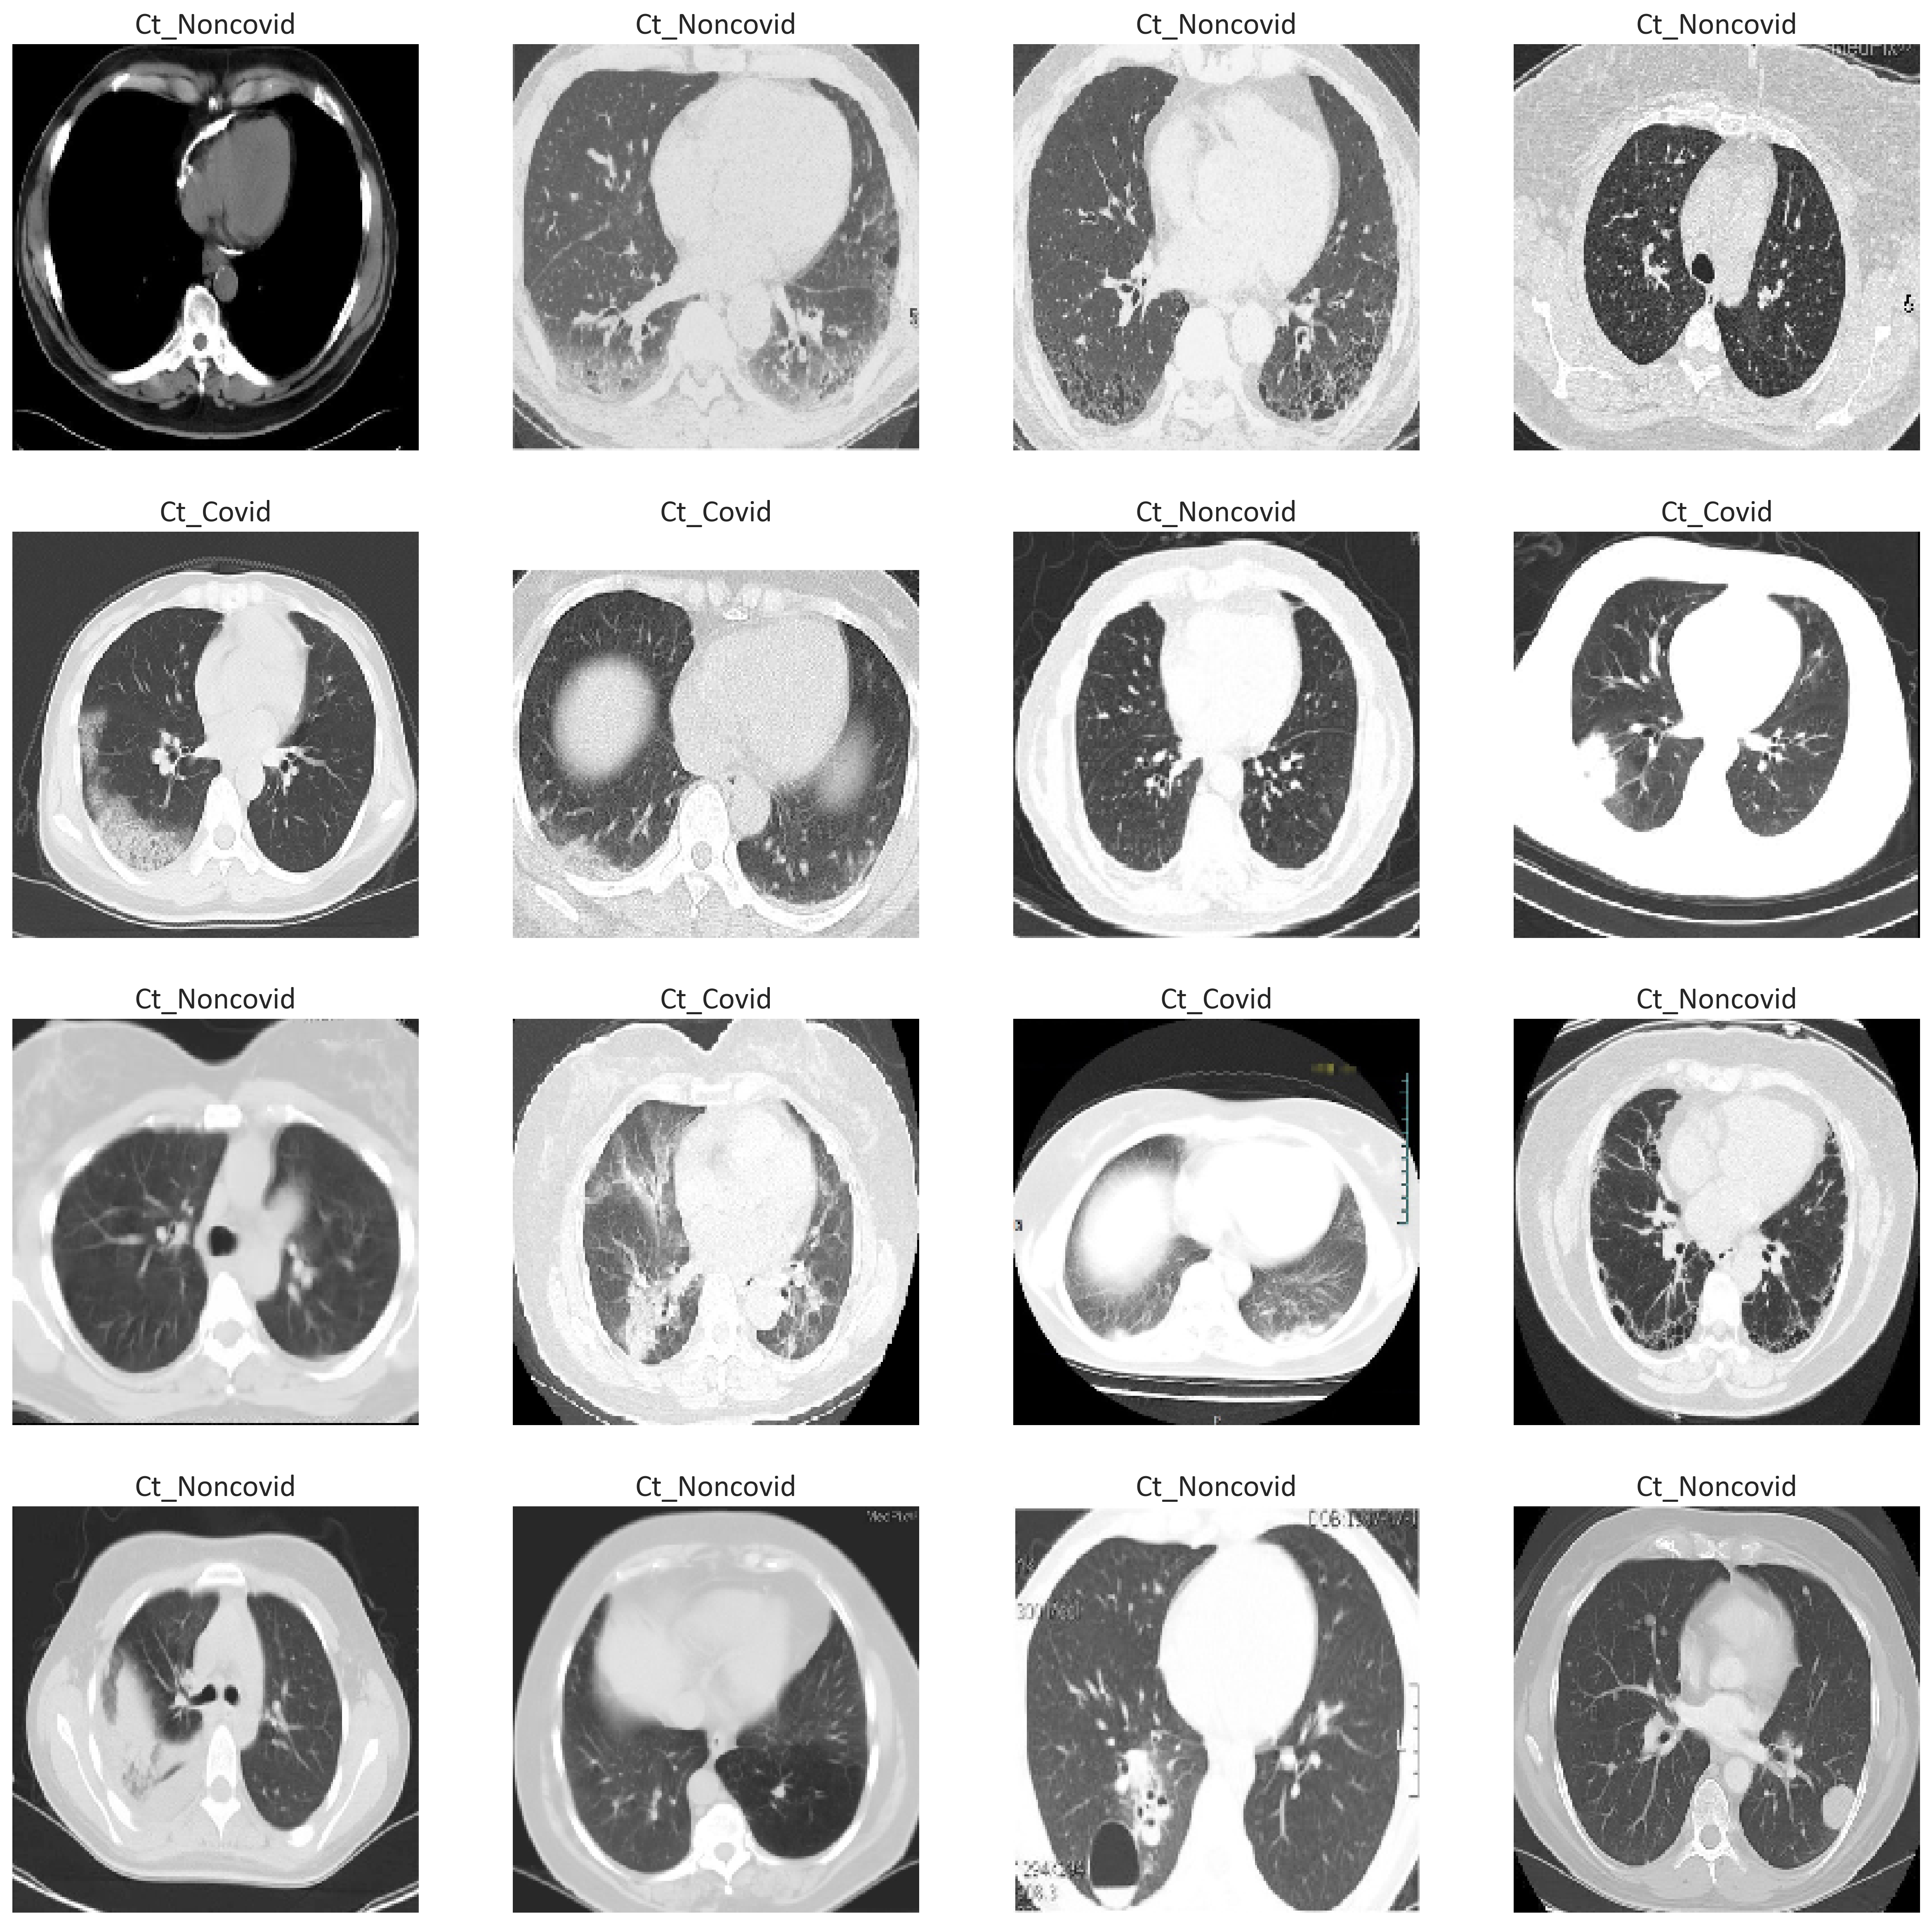

In [42]:
import keras
import numpy as np
covid_19_data = r"C:\Users\i5 lenov\Desktop\Next_Chapter\source_code\cov_19_ct_scans"
covid_19_training_data = image_dataset_from_directory(covid_19_data,seed = 123, validation_split = 0.2, subset = "training",  image_size = (180, 180), batch_size = 16)
covid_19_validation_data = image_dataset_from_directory(covid_19_data, seed = 123, validation_split = 0.2, subset = "validation",image_size = (180, 180),batch_size = 16)
covid_19_training_data_categories = np.array(covid_19_training_data.class_names)
covid_19_generated_image_data = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
covid_19_generated_image_data_for_training = covid_19_generated_image_data.flow_from_directory(covid_19_data,  target_size = (180, 180),  class_mode = "categorical",  shuffle = True, batch_size = 16)
covid_19_images, covid_19_labels = next(iter(covid_19_generated_image_data_for_training))
def covid_19_images_function(covid_19_images, covid_19_labels):
    plt.figure(figsize = (20, 20))
    for n in range(16):
        ax = plt.subplot(4, 4, n+1)
        plt.imshow(covid_19_images[n])
        plt.title(covid_19_training_data_categories[covid_19_labels[n]==1][0].title())
        plt.axis("off")
covid_19_images_function(covid_19_images, covid_19_labels)

In [27]:
covid_19_experimental_tuning = tf.data.experimental.AUTOTUNE
covid_19_training_data = covid_19_training_data.cache().shuffle(1000).prefetch(buffer_size = covid_19_experimental_tuning)
covid_19_validation_data = covid_19_validation_data.cache().prefetch(buffer_size = covid_19_experimental_tuning)

In [28]:
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
covid_19_convolutional_net_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation = "relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(255, activation="relu"),
  tf.keras.layers.Dense(3)
])

In [29]:
covid_19_convolutional_net_model.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ["accuracy"])
covid_19_convolutional_net_model_history = covid_19_convolutional_net_model.fit(covid_19_training_data, validation_data = covid_19_validation_data, epochs = 64)

Epoch 1/64
38/38 [==============================] - 26s 672ms/step - loss: 0.8814 - accuracy: 0.5595 - val_loss: 0.5806 - val_accuracy: 0.7248
Epoch 2/64
38/38 [==============================] - 24s 639ms/step - loss: 0.5553 - accuracy: 0.7085 - val_loss: 0.4841 - val_accuracy: 0.7383
Epoch 3/64
38/38 [==============================] - 24s 644ms/step - loss: 0.4407 - accuracy: 0.7839 - val_loss: 0.4978 - val_accuracy: 0.7248
Epoch 4/64
38/38 [==============================] - 25s 661ms/step - loss: 0.3678 - accuracy: 0.8425 - val_loss: 0.4566 - val_accuracy: 0.7919
Epoch 5/64
38/38 [==============================] - 24s 627ms/step - loss: 0.3305 - accuracy: 0.8543 - val_loss: 0.4737 - val_accuracy: 0.8054
Epoch 6/64
38/38 [==============================] - 28s 729ms/step - loss: 0.2988 - accuracy: 0.8878 - val_loss: 0.5395 - val_accuracy: 0.7718
Epoch 7/64
38/38 [==============================] - 26s 682ms/step - loss: 0.1968 - accuracy: 0.9213 - val_loss: 0.6046 - val_accuracy: 0.8389

Epoch 57/64
38/38 [==============================] - 27s 697ms/step - loss: 2.4149e-05 - accuracy: 1.0000 - val_loss: 1.6329 - val_accuracy: 0.8121
Epoch 58/64
38/38 [==============================] - 26s 697ms/step - loss: 2.3115e-05 - accuracy: 1.0000 - val_loss: 1.6339 - val_accuracy: 0.8121
Epoch 59/64
38/38 [==============================] - 26s 682ms/step - loss: 2.3358e-05 - accuracy: 1.0000 - val_loss: 1.6443 - val_accuracy: 0.8121
Epoch 60/64
38/38 [==============================] - 25s 664ms/step - loss: 2.1040e-05 - accuracy: 1.0000 - val_loss: 1.6399 - val_accuracy: 0.8121
Epoch 61/64
38/38 [==============================] - 28s 737ms/step - loss: 2.1235e-05 - accuracy: 1.0000 - val_loss: 1.6541 - val_accuracy: 0.8121
Epoch 62/64
38/38 [==============================] - 26s 674ms/step - loss: 2.0932e-05 - accuracy: 1.0000 - val_loss: 1.6545 - val_accuracy: 0.8121
Epoch 63/64
38/38 [==============================] - 28s 740ms/step - loss: 1.8325e-05 - accuracy: 1.0000 - val_

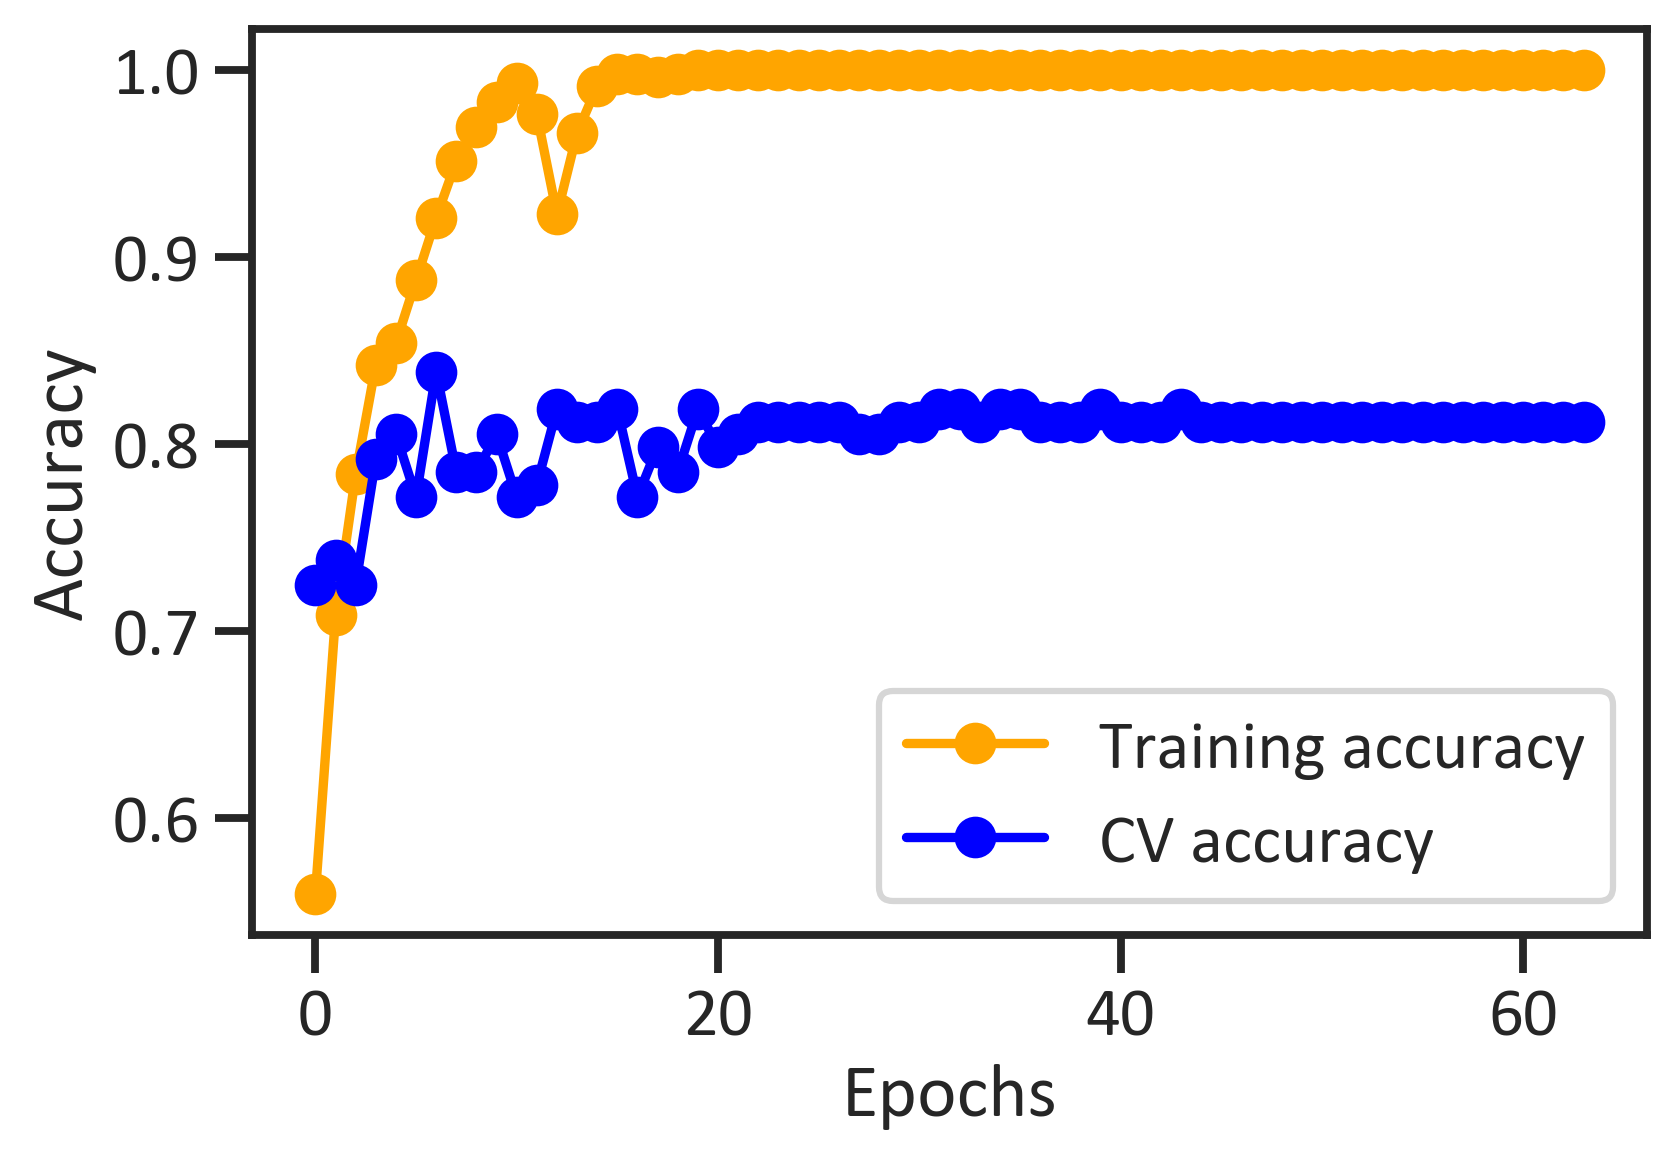

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("talk","ticks", font_scale = 1, font = "Calibri")
from pylab import rcParams
plt.rcParams["figure.dpi"] = 300
plt.plot(covid_19_convolutional_net_model_history.history["accuracy"],
         color = "orange",
         marker = "o",
         label = "Training accuracy")
plt.plot(covid_19_convolutional_net_model_history.history["val_accuracy"],
         color = "blue",
         marker = "o",
         label = "CV accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "best")
plt.show()

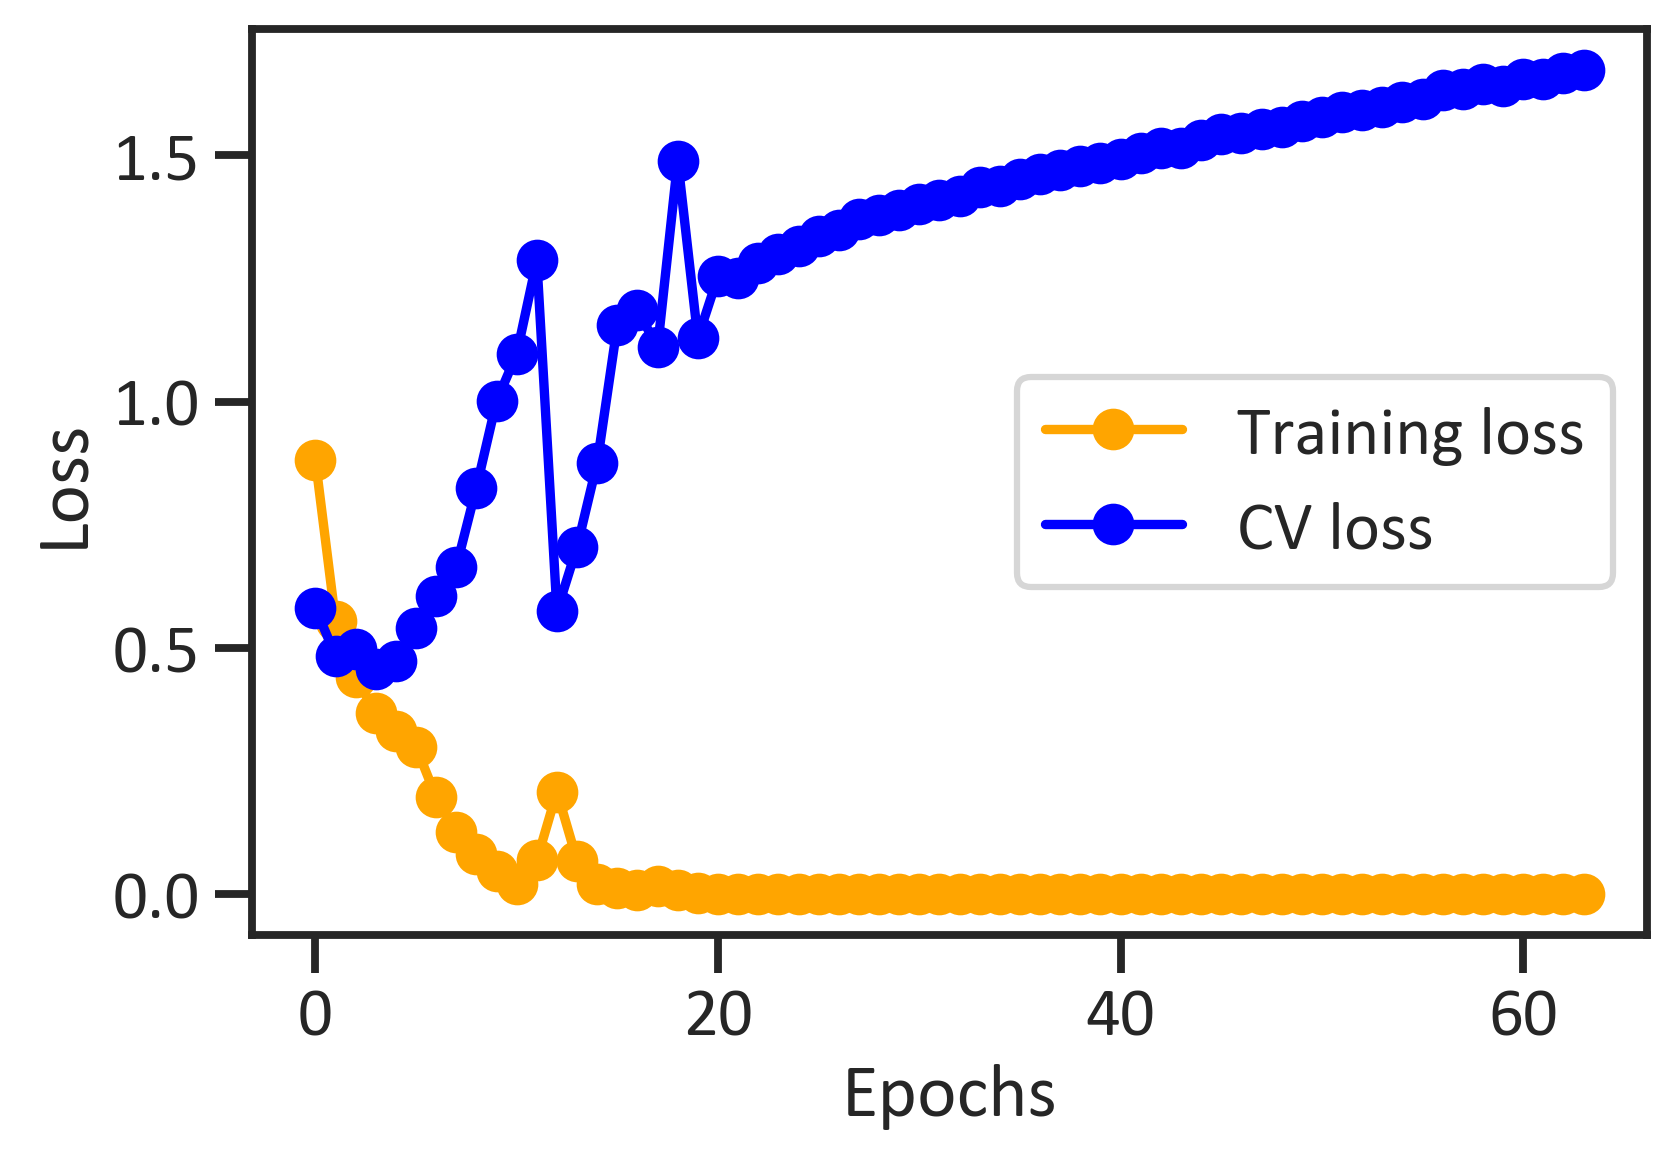

In [31]:
plt.plot(covid_19_convolutional_net_model_history.history["loss"],
         color = "orange",
         marker = "o",
         label = "Training loss")
plt.plot(covid_19_convolutional_net_model_history.history["val_loss"],
         color = "blue",
         marker = "o",
         label = "CV loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc = "best")
plt.show()